In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import torch
from sqlalchemy import create_engine


import os
from dotenv import load_dotenv

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

load_dotenv()

True

# Работа с признаками

In [38]:
conn = psycopg2.connect(os.environ["POSTGRES_CONN"])

## Таблица с постами

In [88]:
# Таблица с постами
post_text_df = pd.read_sql("SELECT * FROM post_text_df", conn)
post_text_df

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [89]:
# Приведение текста к одному виду

import re
import string
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("wordnet")
wnl = nltk.stem.WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

tfidf

[nltk_data] Downloading package wordnet to /Users/dmitry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TfidfVectorizer(preprocessor=<function preprocessing at 0x14a47a200>,
                stop_words='english')

In [90]:
tfidf_data = (
    tfidf
    .fit_transform(post_text_df['text'])
    .toarray()
)

tfidf_data = pd.DataFrame(
    tfidf_data,
    index=post_text_df.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data.head()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# Кластеризация текстов

centered = tfidf_data - tfidf_data.mean()

pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)


kmeans = KMeans(n_clusters=10, random_state=0).fit(pca_decomp)

post_text_df['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster
0,0.499208,0.437103,0.442090,0.445068,0.515233,0.475119,0.344357,0.464294,0.497889,0.493457
1,0.372002,0.284787,0.296910,0.297847,0.245204,0.337963,0.163769,0.331056,0.370773,0.369843
2,0.392807,0.308400,0.329386,0.323626,0.454506,0.360193,0.192626,0.354566,0.384143,0.400630
3,0.320347,0.256539,0.290611,0.264920,0.402382,0.317413,0.128008,0.298641,0.346469,0.358075
4,0.296699,0.168900,0.224248,0.178144,0.364273,0.257420,0.108576,0.233007,0.290084,0.345848


In [92]:
post_text_df = pd.concat((post_text_df,dists_df), axis=1)

post_text_df.head()

,post_id,text,topic,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,6,0.499208,0.437103,0.442090,0.445068,0.515233,0.475119,0.344357,0.464294,0.497889,0.493457
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,6,0.372002,0.284787,0.296910,0.297847,0.245204,0.337963,0.163769,0.331056,0.370773,0.369843
2,3,Asian quake hits European shares\n\nShares in ...,business,6,0.392807,0.308400,0.329386,0.323626,0.454506,0.360193,0.192626,0.354566,0.384143,0.400630
3,4,India power shares jump on debut\n\nShares in ...,business,6,0.320347,0.256539,0.290611,0.264920,0.402382,0.317413,0.128008,0.298641,0.346469,0.358075
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6,0.296699,0.168900,0.224248,0.178144,0.364273,0.257420,0.108576,0.233007,0.290084,0.345848


In [93]:
# Загружаем признаки в БД
engine = create_engine(
    os.environ["POSTGRES_CONN"]
)


post_text_df.to_sql(
    'd_trubitsin_post_feachures_base', 
    con=engine, if_exists='replace'
) 

23

In [23]:
# Почистим переменные

del wnl
del tfidf
del pca
del PCA
del KMeans
del preprocessing

del tfidf_data
del centered
del pca_decomp
del kmeans
del dists_columns
del dists_df
del engine

import gc

gc.collect()

1840

###  Эмбеддинг для текста 

(для модели с использованием DL)

In [64]:
vector = torch.load('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/df_vector')
vector

array([[-0.04026394, -0.27968097, -0.02639238, ...,  0.257868  ,
         0.18739226,  0.31604615],
       [-0.10243215, -0.29358044,  0.02447986, ...,  0.19320787,
         0.10278795,  0.06712697],
       [-0.17103201, -0.196974  ,  0.11955357, ...,  0.11110002,
         0.16093004,  0.06588535],
       ...,
       [-0.23448637, -0.46378005,  0.46819142, ...,  0.14383662,
         0.31123495, -0.15421167],
       [-0.03112065, -0.23907664,  0.12080344, ...,  0.23640299,
         0.34705564,  0.07306456],
       [-0.55892557, -0.23251152,  0.05662002, ...,  0.05255096,
         0.51426667,  0.06540442]], dtype=float32)

In [21]:
# Создание экземпляра модели k ближайших соседей
knn = NearestNeighbors(n_neighbors=5, metric='cosine')

# Обучение модели на эмбеддингах
knn.fit(vector)

# Получение расстояний и индексов k ближайших соседей для каждого эмбеддинга
distances, indices = knn.kneighbors(vector)

# Преобразование расстояний и индексов в числовые признаки
# Например, можно использовать среднее расстояние до k ближайших соседей
vec_to_num = distances.mean(axis=1)
vec_to_num

array([0.08227593, 0.11509974, 0.06522653, ..., 0.11990206, 0.10609498,
       0.12071379], dtype=float32)

In [6]:
post_text_df['vector_knn'] = vec_to_num
post_text_df.head()

,post_id,text,topic,vector_knn
0,1,UK economy facing major risks\n\nThe UK manufa...,business,0.082276
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,0.115100
2,3,Asian quake hits European shares\n\nShares in ...,business,0.065227
3,4,India power shares jump on debut\n\nShares in ...,business,0.166756
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,0.128059


In [67]:
pca = PCA(n_components=40)
pca_decomp = pca.fit_transform(vector)


kmeans = KMeans(n_clusters=20, random_state=0).fit(pca_decomp)

post_text_df['TextCluster'] = kmeans.labels_

dists_columns = ['DistanceTo1thCluster',
                 'DistanceTo2thCluster',
                 'DistanceTo3thCluster',
                 'DistanceTo4thCluster',
                 'DistanceTo5thCluster',
                 'DistanceTo6thCluster',
                 'DistanceTo7thCluster',
                 'DistanceTo8thCluster',
                 'DistanceTo9thCluster',
                 'DistanceTo10thCluster',
                 'DistanceTo11thCluster',
                 'DistanceTo12thCluster',
                 'DistanceTo13thCluster',
                 'DistanceTo14thCluster',
                 'DistanceTo15thCluster',
                 'DistanceTo16thCluster',
                 'DistanceTo17thCluster',
                 'DistanceTo18thCluster',
                 'DistanceTo19thCluster',
                 'DistanceTo20thCluster']

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,4.362444,2.674125,3.371718,3.767566,2.338804,2.881910,3.699660,3.382760,4.351871,3.919885,3.611069,3.053432,3.286143,2.840334,3.744094,2.491706,3.129261,2.619751,3.445884,1.595424
1,4.158804,2.378566,3.078755,3.396635,2.251432,2.302076,3.199784,3.092818,3.744603,3.545325,3.413750,2.708527,2.770329,2.524673,3.483526,1.806930,2.886565,2.271507,2.951837,2.192610
2,4.094269,2.680975,3.043988,3.664985,1.973834,2.761580,3.556235,3.214981,4.111701,3.811369,3.411801,2.796179,2.939573,2.824516,3.409193,2.736978,3.148608,2.491807,3.125579,1.744144
3,3.658117,2.518122,3.070946,3.102835,1.905770,2.797023,3.202825,3.050293,3.651233,3.310941,3.169094,2.835556,2.985060,2.959170,3.246251,2.622577,3.174929,2.417456,2.994532,2.227100
4,4.074733,2.726529,3.140178,3.047300,2.203277,2.547652,3.014682,2.944147,3.686146,3.440603,3.248507,2.985764,2.933058,3.084004,3.297000,3.208571,2.916335,2.882773,3.080729,2.543990


In [70]:
post_text_df = pd.concat((post_text_df,dists_df), axis=1)

post_text_df.head()

,post_id,text,topic,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,...,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,DistanceTo16thCluster,DistanceTo17thCluster,DistanceTo18thCluster,DistanceTo19thCluster,DistanceTo20thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,4.362444,2.674125,3.371718,3.767566,2.338804,2.881910,3.699660,...,3.611069,3.053432,3.286143,2.840334,3.744094,2.491706,3.129261,2.619751,3.445884,1.595424
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,4.158804,2.378566,3.078755,3.396635,2.251432,2.302076,3.199784,...,3.413750,2.708527,2.770329,2.524673,3.483526,1.806930,2.886565,2.271507,2.951837,2.192610
2,3,Asian quake hits European shares\n\nShares in ...,business,4.094269,2.680975,3.043988,3.664985,1.973834,2.761580,3.556235,...,3.411801,2.796179,2.939573,2.824516,3.409193,2.736978,3.148608,2.491807,3.125579,1.744144
3,4,India power shares jump on debut\n\nShares in ...,business,3.658117,2.518122,3.070946,3.102835,1.905770,2.797023,3.202825,...,3.169094,2.835556,2.985060,2.959170,3.246251,2.622577,3.174929,2.417456,2.994532,2.227100
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,4.074733,2.726529,3.140178,3.047300,2.203277,2.547652,3.014682,...,3.248507,2.985764,2.933058,3.084004,3.297000,3.208571,2.916335,2.882773,3.080729,2.543990


In [71]:
# Загружаем признаки в БД
engine = create_engine(
    os.environ["POSTGRES_CONN"]
)


post_text_df.to_sql(
    'd_trubitsin_post_feachures_dl', 
    con=engine, if_exists='replace'
) 

23

In [10]:
# Почистим переменные

del vector
del pca
del PCA
del NearestNeighbors
del torch

del distances
del indices
del vec_to_num
del vector_reduced
del engine

import gc

gc.collect()

NameError: name 'vector' is not defined

## Таблица с действиями пользователей

In [72]:
# Выделение признаков из времени
# Получение данных по каждому пользователю
# Удаление действий "like" из-за избыточности
# Объединение с таблицей с пользователями

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(os.environ["POSTGRES_CONN"])
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)


feed_data = batch_load_sql(
    """
      SELECT
        cast(extract(hour from timestamp) as int) as hour,
        cast(extract(dow from timestamp) as int) as weekday,
        f.timestamp,
        f.user_id,
        f.post_id,
        u.gender,
        u.age,
        u.country,
        u.city,
        u.exp_group,
        u.os,
        u.source,
        f.target
          
      FROM (
        SELECT *,
              ROW_NUMBER() OVER (PARTITION BY user_id) as row_num
        FROM public.feed_data
      ) AS f

      JOIN public.user_data AS u
      ON f.user_id = u.user_id

      WHERE action = 'view'
      AND row_num <= 20
      
      LIMIT 5000000
    """
)

feed_data.head()

,hour,weekday,timestamp,user_id,post_id,gender,age,country,city,exp_group,os,source,target
0,23,6,2021-11-20 23:26:37,200,1460,1,34,Russia,Degtyarsk,3,Android,ads,0
1,8,2,2021-11-23 08:55:23,200,3089,1,34,Russia,Degtyarsk,3,Android,ads,1
2,8,2,2021-11-23 08:56:43,200,6877,1,34,Russia,Degtyarsk,3,Android,ads,0
3,8,2,2021-11-23 08:57:53,200,2376,1,34,Russia,Degtyarsk,3,Android,ads,1
4,8,2,2021-11-23 08:59:34,200,924,1,34,Russia,Degtyarsk,3,Android,ads,0


In [35]:
feed_data.shape

(2926352, 13)

In [36]:
feed_data.nunique()

hour              19
weekday            7
timestamp    1391972
user_id       163205
post_id         6831
gender             2
age               76
country           11
city            3915
exp_group          5
os                 2
source             2
target             2
dtype: int64

In [73]:
data = pd.merge(
    feed_data,
    post_text_df.drop('text', axis=1),
    on='post_id',
    how='left'
)

del feed_data
del post_text_df

data = data.set_index(['user_id', 'post_id'])

data.head(20)

hour  weekday           timestamp  gender  age country  \
user_id post_id                                                           
200     1460       23        6 2021-11-20 23:26:37       1   34  Russia   
        3089        8        2 2021-11-23 08:55:23       1   34  Russia   
        6877        8        2 2021-11-23 08:56:43       1   34  Russia   
        2376        8        2 2021-11-23 08:57:53       1   34  Russia   
        924         8        2 2021-11-23 08:59:34       1   34  Russia   
        3850        9        2 2021-11-23 09:00:50       1   34  Russia   
        6621        9        2 2021-11-23 09:03:10       1   34  Russia   
        4565        9        2 2021-11-23 09:04:00       1   34  Russia   
        45          9        2 2021-11-23 09:06:32       1   34  Russia   
        6731        9        2 2021-11-23 09:09:12       1   34  Russia   
        4438        9        2 2021-11-23 09:10:50       1   34  Russia   
        3421        9        2 2021-11-23 09:11:08       1   34  Russia   
        1652        9        2 2021-11-23 09:14:05       1   34  Russia   
        405         9        2 2021-11-23 09:15:17       1   34  Russia   
        3020        9        2 2021-11-23 09:17:38       1   34  Russia   
        2246        9        2 2021-11-23 09:19:30       1   34  Russia   
201     4368       21        3 2021-11-17 21:25:54       0   37  Russia   
        2339       21        3 2021-11-17 21:28:31       0   37  Russia   
        1411       21        3 2021-11-17 21:29:26       0   37  Russia   
        1443       21        3 2021-11-17 21:29:48       0   37  Russia   

                      city  exp_group       os source  ...  \
user_id post_id                                        ...   
200     1460     Degtyarsk          3  Android    ads  ...   
        3089     Degtyarsk          3  Android    ads  ...   
        6877     Degtyarsk          3  Android    ads  ...   
        2376     Degtyarsk          3  Android    ads  ...   
        924      Degtyarsk          3  Android    ads  ...   
        3850     Degtyarsk          3  Android    ads  ...   
        6621     Degtyarsk          3  Android    ads  ...   
        4565     Degtyarsk          3  Android    ads  ...   
        45       Degtyarsk          3  Android    ads  ...   
        6731     Degtyarsk          3  Android    ads  ...   
        4438     Degtyarsk          3  Android    ads  ...   
        3421     Degtyarsk          3  Android    ads  ...   
        1652     Degtyarsk          3  Android    ads  ...   
        405      Degtyarsk          3  Android    ads  ...   
        3020     Degtyarsk          3  Android    ads  ...   
        2246     Degtyarsk          3  Android    ads  ...   
201     4368        Abakan          0  Android    ads  ...   
        2339        Abakan          0  Android    ads  ...   
        1411        Abakan          0  Android    ads  ...   
        1443        Abakan          0  Android    ads  ...   

                 DistanceTo11thCluster DistanceTo12thCluster  \
user_id post_id                                                
200     1460                  3.087005              2.789466   
        3089                  3.526146              3.798101   
        6877                  2.116119              2.170663   
        2376                  3.875253              3.951237   
        924                   2.630947              1.619921   
        3850                  3.818655              4.209367   
        6621                  2.375619              1.637093   
        4565                  2.460687              2.816818   
        45                    3.256210              3.027446   
        6731                  3.178572              3.970731   
        4438                  2.027936              2.265487   
        3421                  4.031527              3.923350   
        1652                  3.712864              3.257639   
        405                   2.942628   

In [48]:
data.to_csv('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/data/data_dl_2.csv')

In [80]:
data = pd.read_csv('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/data/data_ml_1.csv')

## Разделение на трейн и тест

In [3]:
print(f'Начальная дата: {min(data["timestamp"])}')
print(f'Конечная дата: {max(data["timestamp"])}')

Начальная дата: 2021-10-01 06:01:40
Конечная дата: 2021-12-29 23:51:06


In [82]:
data_train = data[data.timestamp < '2021-12-15']
data_test = data[data.timestamp >= '2021-12-15']

data_train = data_train.drop(['timestamp', 'os', 'source'], axis=1)
data_test = data_test.drop(['timestamp', 'os', 'source'], axis=1)

X_train = data_train.drop('target', axis=1)
X_test = data_test.drop('target', axis=1)

y_train = data_train['target']
y_test = data_test['target']

y_train.shape, y_test.shape

((2370056,), (555930,))

In [83]:
# Синхронизация порядка колонок с эндпоинтом control
cols_ = [
    'topic', 'TextCluster', 'DistanceTo1thCluster', 'DistanceTo2thCluster',
       'DistanceTo3thCluster', 'DistanceTo4thCluster', 'DistanceTo5thCluster',
       'DistanceTo6thCluster', 'DistanceTo7thCluster', 'DistanceTo8thCluster',
       'DistanceTo9thCluster', 'DistanceTo10thCluster', 'gender', 'age',
       'country', 'city', 'exp_group', 'weekday', 'hour'
]

X_train = X_train[cols_]
X_test = X_test[cols_]

In [75]:
# Синхронизация порядка колонок с эндпоинтом test
cols_ = [
    'topic', 'DistanceTo1thCluster', 'DistanceTo2thCluster',
       'DistanceTo3thCluster', 'DistanceTo4thCluster', 'DistanceTo5thCluster',
       'DistanceTo6thCluster', 'DistanceTo7thCluster', 'DistanceTo8thCluster',
       'DistanceTo9thCluster', 'DistanceTo10thCluster',
       'DistanceTo11thCluster', 'DistanceTo12thCluster',
       'DistanceTo13thCluster', 'DistanceTo14thCluster',
       'DistanceTo15thCluster', 'DistanceTo16thCluster',
       'DistanceTo17thCluster', 'DistanceTo18thCluster',
       'DistanceTo19thCluster', 'DistanceTo20thCluster', 'gender', 'age',
       'country', 'city', 'exp_group'
]

X_train = X_train[cols_]
X_test = X_test[cols_]


In [6]:
del data

# Обучение модели

In [7]:
from catboost import CatBoostClassifier
from sklearn.model_selection import ShuffleSplit

In [84]:
cat_feachures = list(X_train.select_dtypes(include=object).columns)

cat_feachures

['topic', 'country', 'city']

In [85]:
model = CatBoostClassifier(cat_features=cat_feachures, custom_loss='AUC')
 
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50, early_stopping_rounds=80, plot=True)

model.save_model('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/model/catboost_ml_1')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.21601
0:	learn: 0.5461505	test: 0.5472422	best: 0.5472422 (0)	total: 1.57s	remaining: 26m 6s
50:	learn: 0.3390592	test: 0.3442343	best: 0.3442343 (50)	total: 46.6s	remaining: 14m 26s
100:	learn: 0.3370561	test: 0.3427783	best: 0.3427783 (100)	total: 1m 29s	remaining: 13m 16s
150:	learn: 0.3358368	test: 0.3419895	best: 0.3419895 (150)	total: 2m 13s	remaining: 12m 30s
200:	learn: 0.3349770	test: 0.3415335	best: 0.3415314 (199)	total: 2m 57s	remaining: 11m 46s
250:	learn: 0.3343856	test: 0.3412398	best: 0.3412398 (250)	total: 3m 40s	remaining: 10m 57s
300:	learn: 0.3337081	test: 0.3408866	best: 0.3408866 (300)	total: 4m 21s	remaining: 10m 7s
350:	learn: 0.3331047	test: 0.3406279	best: 0.3406274 (349)	total: 5m 4s	remaining: 9m 23s
400:	learn: 0.3326393	test: 0.3404404	best: 0.3404404 (400)	total: 5m 47s	remaining: 8m 39s
450:	learn: 0.3320869	test: 0.3401822	best: 0.3401818 (449)	total: 6m 30s	remaining: 7m 55s
500:	learn: 0.3317025	test: 0.3400198	best: 0.3400188 (

In [86]:
from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.7124332680796155
Качество на тесте: 0.6882050146255063


In [78]:
from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.7124278450639056
Качество на тесте: 0.6847652014201863


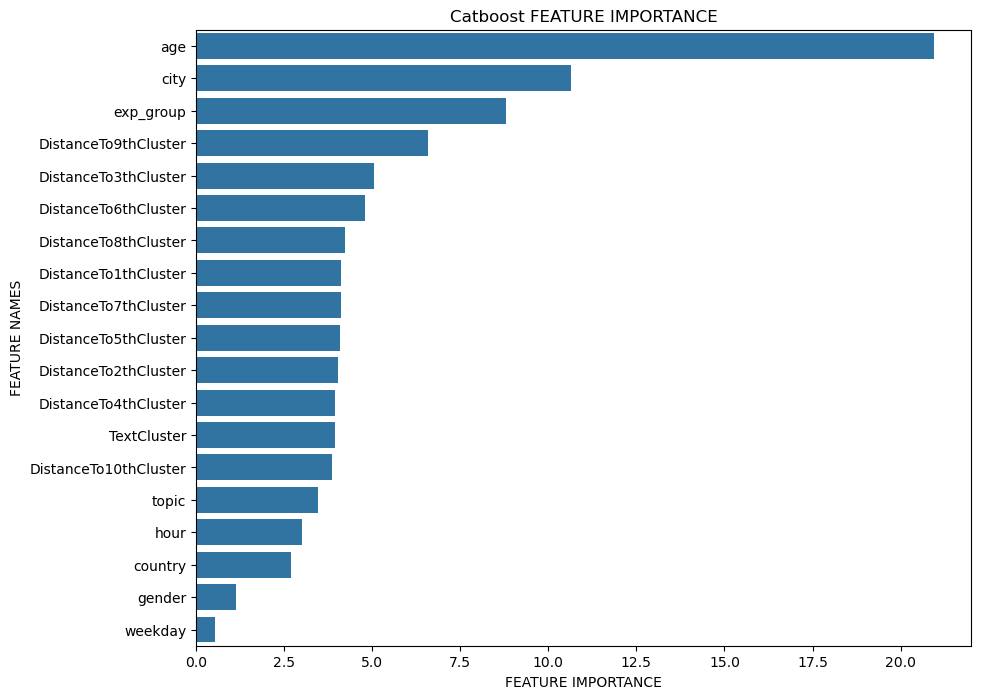

In [94]:
### Посмотрим на feature_importance

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.feature_importances_,X_train.columns,'Catboost')

In [106]:
model = CatBoostClassifier(random_state=8, cat_features=cat_feachures, verbose=50, early_stopping_rounds=50, custom_loss='AUC')
param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.1, 0.15, 0.2]
}

splitter = ShuffleSplit(n_splits=3)

grid_search = model.grid_search(param_grid=param_grid,
                                X=X_train, y=y_train, cv=splitter, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6197067	test: 0.6192660	best: 0.6192660 (0)	total: 235ms	remaining: 3m 54s
50:	learn: 0.3443244	test: 0.3392335	best: 0.3392335 (50)	total: 7.54s	remaining: 2m 20s
100:	learn: 0.3411493	test: 0.3368896	best: 0.3368896 (100)	total: 15.9s	remaining: 2m 21s
150:	learn: 0.3393908	test: 0.3360720	best: 0.3360720 (150)	total: 24.9s	remaining: 2m 19s
200:	learn: 0.3377912	test: 0.3353557	best: 0.3353517 (199)	total: 33.3s	remaining: 2m 12s
250:	learn: 0.3365797	test: 0.3350880	best: 0.3350880 (250)	total: 41.8s	remaining: 2m 4s
300:	learn: 0.3353763	test: 0.3348716	best: 0.3348634 (296)	total: 50.5s	remaining: 1m 57s
350:	learn: 0.3343930	test: 0.3347194	best: 0.3347194 (350)	total: 59s	remaining: 1m 49s
400:	learn: 0.3335007	test: 0.3346250	best: 0.3346151 (391)	total: 1m 7s	remaining: 1m 40s
450:	learn: 0.3326274	test: 0.3345350	best: 0.3345347 (447)	total: 1m 15s	remaining: 1m 32s
500:	learn: 0.3318063	test: 0.3344597	best: 0.3344576 (498)	total: 1m 24s	remaining: 1m 23s
550:	l

In [74]:
best_params = grid_search['params']
best_params

{'depth': 8, 'l2_leaf_reg': 2}

In [75]:
best_model = CatBoostClassifier(**best_params, random_state=8, early_stopping_rounds=50,
                                custom_loss=['AUC', 'Accuracy'],  cat_features=cat_feachures)

best_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)

model.save_model('/Users/dmitry/Documents/code/Start_ML/module_2/final_project/model/catboost_4_5')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))